# Light Schrödinger Bridge Night to Day Domain Transform

This notebooks trains the LightSB model using the AutoencoderKL latents we generated. It will perform a grid search over the n_potentials, is_diagonal and epsilon parameters to get the best performing model.

Next, it performs a transformation on the night validation set. Finally, we decode these latents back into images using the encoder and save them separately to the data folder.

## Imports

In [6]:
import os, sys

# if colab, mount drive and get the git repo
if 'google.colab' in sys.modules:
    from google.colab import drive
    print(os.getcwd())
    drive.mount('/content/drive')
    !git clone --recurse-submodules https://github.com/jsluijter02/LightSB_YOLO

    # Append LightSB_YOLO path
    sys.path.append(os.path.join(os.getcwd(), 'LightSB_YOLO'))

    ## TODO: 

# otherwise local path append
else:
    sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
import os, sys
import numpy as np
np.random.seed(0)
from argparse import Namespace
import copy
import torch
import diffusers
from datetime import date

from scripts.utils import dirs
dirs.add_LIGHTSB_to_PATH()

from scripts.models.autoencoderkl import AutoencoderKL_BDD
from scripts.models.lightsb import LightSB_BDD
from scripts.evals.FID import latent_FID_score
from scripts.utils import img

## Encoder Model

In [ ]:
encoder = AutoencoderKL_BDD()

## Load Data

In [ ]:
data_dir = dirs.get_data_dir()
latent_dir = os.path.join(data_dir, "encodings")

# Only save Val_night -> others are redundant
train_day_latents, _  = encoder.load_latents(os.path.join(latent_dir, "train_day.npz"))
train_night_latents, _ = encoder.load_latents(os.path.join(latent_dir, "train_night.npz"))

val_day_latents, _ = encoder.load_latents(os.path.join(latent_dir, "val_day.npz"))
val_night_latents, val_night_filenames = encoder.load_latents(os.path.join(latent_dir, "val_night.npz"))

np_data = {"train_day": train_day_latents, 
           "train_night": train_night_latents, 
           "val_day": val_day_latents, 
           "val_night": val_night_latents}

## Load Light Schrödinger Bridge model

In [ ]:
sb_config = LightSB_BDD.standard_config()
sb = LightSB_BDD(sb_config, np_data=np_data)

## Train SB with a Grid Search + Val Set Evaluation
To get a sense of parameter's effectiveness on the transformation, this step performs a grid search and saves the best parameters and state dictionary.

Evaluation method: FID on latents.

Due to computational and time constraints, it is not possible to transform ALL images six times and produce FID-scores, so a latent-based proxy is taken to determine final LightSB model parameters. FID metric on images will be taken of the final image set.

This is different from actual FID metric, as this takes the metric on features learned from a CNN.

Additionally, downstream, the mAP of the YOLOPX algorithm will determine this method's succesfullness as a preprocessing step.

### Grid Search Parameters

In [ ]:
epsilons = [0.01, 0.1, 0.5]
n_potentials = [10, 20]
is_diagonal = ... # Doesn't work on mac, but it 
max_steps = [1000, 10000, 50000]

### Grid Search Setup

In [ ]:
args = Namespace()

models = {}
fid_scores = {}
sample_indices = img.sample_indices(len(sb.X_test), how_many=5)

best = {
    "name": None,
    "fid": None,
    "state_dict": None,
    "epsilon" : None,
    "max_steps": None,
    "n_potentials": None
}

date = date.today().strftime('%Y%m%d')
runs_path = os.path.join(dirs.get_base_dir(), "runs", "LightSB_GridSearch", date)
os.makedirs(runs_path, exist_ok=True)

### Grid Search Loop + Internal Val Set Eval

In [ ]:
for eps in epsilons:
    for potential in n_potentials:
        for steps in max_steps:
            print("Started process for: ", steps, " ", eps, " ", potential)
            # to reduce training time, reduce steps to 1000
            args.MAX_STEPS = steps
            args.EPSILON = eps
            args.N_POTENTIALS = potential

            print("Reloading model")
            sb.update_config(args=args)
            sb.reload_model()
            print("Reloaded model")

            print("Training model")
            sb.train()
            print("Trained model")

            print("Transforming Validation Latents")
            transformed = sb.transform(sb.X_test)

            fid = latent_FID_score(transformed, sb.Y_test)
            print("FID-score on latents: ", fid)

            state_dict = copy.deepcopy(sb.model.state_dict())

            save = {
                "fid": fid,
                "state_dict": state_dict,
                "max_steps": steps,
                "epsilon": eps,
                "n_potentials": potential
            }

            model_name = f'{fid}_{eps}_{potential}_{steps}.pt'

            torch.save(save, os.path.join(runs_path, model_name))

            # Save highest FID score's params
            if fid > best["fid"]:
                best["fid"] = fid
                best["epsilon"] = eps
                best["max_steps"] = steps
                best["n_potentials"] = potential
                best["name"] = model_name
                best["state_dict"] = state_dict

            sample_imgs = diffusers.utils.pt_to_pil(encoder.decode_latents(transformed[sample_indices]))
            img.plot_samples(sample_imgs, title=f'Transformed Val Set Images with Params: Steps: {steps}, Epsilon: {eps}, N_potentials: {potential}. FID: {fid}')

In [ ]:
print(f'Best model: {best["name"]}, FID: {best["fid"]}')

## Transform Val Images with Best Model

In [ ]:
best_cfg = LightSB_BDD.standard_config()
best_cfg.MODEL.EPSILON = best["epsilon"]
best_cfg.MODEL.N_POTENTIALS = best["n_potentials"]
best_cfg.MAX_STEPS = best["max_steps"]

best_sb = LightSB_BDD(config=best_cfg, np_data=np_data)

best_sb.load_state_dict(best["state_dict"])

In [ ]:
best_transformed = best_sb.transform(best_sb.X_test)

100%|██████████| 10000/10000 [01:29<00:00, 111.85it/s]


## Save Images to Folder

[3289  191  862 1066 2958]
latents shape:  torch.Size([5, 4096])
reshaped latents shape:  torch.Size([5, 4, 32, 32])
decoded latents shape:  torch.Size([5, 3, 256, 256])


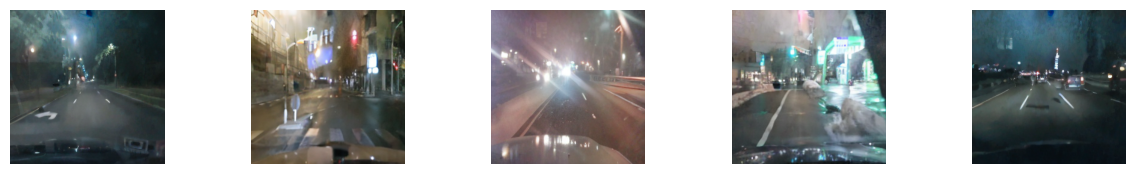

latents shape:  torch.Size([5, 4096])
reshaped latents shape:  torch.Size([5, 4, 32, 32])
decoded latents shape:  torch.Size([5, 3, 256, 256])


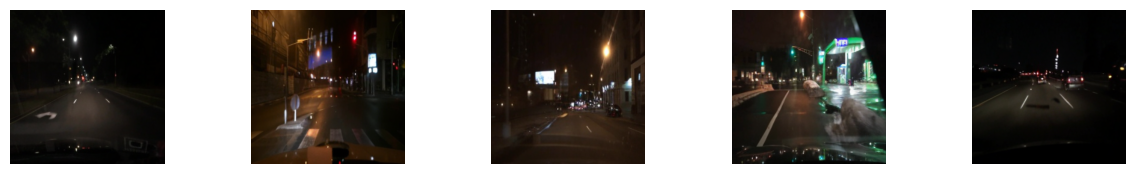

In [ ]:
encoder.save_imgs(best_transformed, filenames=val_night_filenames)